# Transformer on Turkish spectrograms


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim


In [2]:
# load the combined features from the pickle file
import pickle
dir = "E:/ChristianMusaeus/Data/Turkish"
    
# load npy combined_stft_features_19_final
data = np.load(f"{dir}/combined_stft_features_19_final.npy")


labels = data[:,-1]
data = data[:,:-1]





    

In [3]:
class EpochTransformer(nn.Module):
    def __init__(self, n_positions, n_embedding, n_datapoints, num_heads, num_layers):
        super(EpochTransformer, self).__init__()
        self.L = 10000
        self.n_positions = n_positions
        self.n_embedding = n_embedding
        self.n_datapoints = n_datapoints
        encoder_layers = nn.TransformerEncoderLayer(d_model=self.n_embedding, nhead=num_heads, dim_feedforward=1024)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

    def positional_encoding(self, n_positions, n_datapoints, L=10000):
        """
        Generates positional encodings directly to match the size of the data matrix.

        Args:
            n_positions (int): Number of positions (sequence length).
            n_datapoints (int): Number of datapoints (embedding size per epoch).
            L (int): Maximum sequence length (default 10000).

        Returns:
            torch.Tensor: Positional encoding matrix of shape (n_positions, n_datapoints).
        """
        n = torch.arange(n_positions)[:, None]  # (n_positions, 1)
        i = torch.arange(n_datapoints)[None, :]  # (1, n_datapoints)

        # Compute positional encodings using the vectorized formula
        angle_rates = 1 / (L ** (i / n_datapoints))
        angle_rads = n * angle_rates

        # Apply sin to even indices and cos to odd indices
        encoding = torch.zeros_like(angle_rads)
        encoding[:, 0::2] = torch.sin(angle_rads[:, 0::2])
        encoding[:, 1::2] = torch.cos(angle_rads[:, 1::2])

        return encoding

    def add_positional_encoding(self, data_matrix, L=10000):
        """
        Adds positional encoding to the data matrix directly, matching the size of the matrix.

        Args:
            data_matrix (torch.Tensor): The data matrix of shape (batch_size, seq_len, n_datapoints).
            L (int): Maximum sequence length (default 10000).

        Returns:
            torch.Tensor: Data matrix with added positional encoding.
        """
        # Extract the sequence length (seq_len) and embedding size (n_datapoints)
        batch_size, n_positions, n_datapoints = data_matrix.shape  # Handle batch_size

        # Generate positional encoding for the sequence length and embedding size
        pos_enc = self.positional_encoding(n_positions, n_datapoints, L).to(data_matrix.device)
        
        # Add positional encoding to each sequence in the batch
        pos_enc = pos_enc.unsqueeze(0).expand(batch_size, -1, -1)  # Expand to match batch size
        
        # Add the positional encoding to the data matrix
        data_matrix_with_pos_enc = data_matrix + pos_enc
        
        return data_matrix_with_pos_enc


    def forward(self, x):
        x = self.add_positional_encoding(x).float() # convert to float
        output = self.transformer_encoder(x)
        return output  # Compress into a feature vector


In [4]:
class SequenceTransformer(nn.Module):
    def __init__(self, seq_len, embedding_dim, num_heads, num_layers):
        super(SequenceTransformer, self).__init__()
        self.seq_len = seq_len
        self.embedding_dim = embedding_dim
        encoder_layers = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=1024)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
    
    def add_sequence_positional_encoding(self, epoch_matrix, seq_len, embedding_dim):
        """
        Adds positional encoding to the sequence of epochs.
        Args:
            epoch_matrix (torch.Tensor): The sequence of epoch feature vectors (batch_size, seq_len, embedding_dim)
            seq_len (int): Length of the sequence (number of epochs).
            embedding_dim (int): Embedding dimension per epoch.
        Returns:
            torch.Tensor: Sequence with added positional encoding.
        """
        n = torch.arange(seq_len)[:, None]
        i = torch.arange(embedding_dim)[None, :]
        angle_rates = 1 / (10000 ** (i / embedding_dim))
        pos_enc = torch.zeros((seq_len, embedding_dim))
        pos_enc[:, 0::2] = torch.sin(n * angle_rates[:, 0::2]).to(epoch_matrix.device)
        pos_enc[:, 1::2] = torch.cos(n * angle_rates[:, 1::2]).to(epoch_matrix.device)
        
        return epoch_matrix + pos_enc.to(epoch_matrix.device)


    def forward(self, epoch_output_seq):
        # Add positional encoding to the sequence of epoch outputs
        encoded_seq = self.add_sequence_positional_encoding(epoch_output_seq, self.seq_len, self.embedding_dim).float()
        # Pass through the transformer encoder
        output_seq = self.transformer_encoder(encoded_seq)
        return output_seq


In [5]:
class FinalModel(nn.Module):
    def __init__(self, n_positions, n_embedding, seq_len, num_heads, num_layers):
        super(FinalModel, self).__init__()
        # Initialize Epoch Transformer and Sequence Transformer
        self.epoch_transformer = EpochTransformer(n_positions, n_embedding, n_embedding, num_heads, num_layers)
        self.sequence_transformer = SequenceTransformer(seq_len, n_embedding, num_heads, num_layers)
        # Fully connected layers for final classification
        self.fc1 = nn.Linear(n_embedding, 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classification

    def forward(self, x, target_idx):
        """
        Forward pass for the model.
        Args:
            x: Input of shape (batch_size, seq_len, n_datapoints)
            target_idx: The index of the target epoch to classify.
        """
        # Process the batch of epochs through the Epoch Transformer
        batch_size, seq_len, n_datapoints = x.shape
        
        # Pass all epochs in the sequence through the Epoch Transformer
        epoch_outputs = self.epoch_transformer(x)  # Shape: [batch_size, seq_len, n_embedding]
        
        # Process the entire sequence of epochs through the Sequence Transformer
        sequence_output = self.sequence_transformer(epoch_outputs)  # Shape: [batch_size, seq_len, n_embedding]
        
        # Extract the specific epoch representation (e.g., epoch 6) from the sequence
        target_epoch_output = sequence_output[:, target_idx]  # Shape: [batch_size, n_embedding]
        
        # Pass the target epoch's output through fully connected layers for classification
        out = F.relu(self.fc1(target_epoch_output))
        out = self.fc2(out)
        
        return F.sigmoid(out)



In [6]:
model = FinalModel(n_positions=3215, n_embedding=6175, seq_len=11, num_heads=5, num_layers=1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

print(model)
# import model summary
from torchsummary import summary
# model summary

# summary(model, (11, 3925))
# print number of parameters in m,odel
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

FinalModel(
  (epoch_transformer): EpochTransformer(
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=6175, out_features=6175, bias=True)
          )
          (linear1): Linear(in_features=6175, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=6175, bias=True)
          (norm1): LayerNorm((6175,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((6175,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (sequence_transformer): SequenceTransformer(
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): Multihead

In [7]:
# Create a batch of 10 sequences, each with 11 epochs and 6175 features
batch_size = 5
seq_len = 11  # We use 11 epochs in total (5 before, 1 target, 5 after)
n_embedding = 6175  # Number of features per epoch
num_heads = 5

# Initialize the model
model = FinalModel(n_positions=2980, n_embedding=n_embedding, seq_len=seq_len, num_heads=num_heads, num_layers=1)

# Random input tensor of shape [batch_size, seq_len, n_datapoints]
x = torch.randn(batch_size, seq_len, n_embedding)

# We want to classify epoch 6 
target_idx = 5

# Forward pass
output = model(x, target_idx)
print(output.shape, output)  # Should be [batch_size, 1] for binary classification





torch.Size([5, 1]) tensor([[0.4524],
        [0.4357],
        [0.5374],
        [0.5068],
        [0.4712]], grad_fn=<SigmoidBackward0>)


# Making the training loop


In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
from tqdm import tqdm
import torch
import numpy as np

# set seed
torch.manual_seed(7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

# Load the data
n_positions = 2980
batch_size = 128
seq_len = 11  # We use 11 epochs in total (5 before, 1 target, 5 after)
n_embedding = 6175  # Number of features per epoch
num_heads = 5
num_layers = 1
model = FinalModel(n_positions=n_positions, n_embedding=n_embedding, seq_len=seq_len, num_heads=num_heads, num_layers=num_layers).to(device)


logo = LeaveOneGroupOut()
epochs = data

running_train_loss = []
running_val_loss = []
running_val_acc = []

train_loops = 4

patient_ids = np.repeat([1,2,3,4,5,6,7,8,9,10],298) 

y = np.repeat([0,1],1490)
# print(y.shape, y[147:152])  # Should be (1, 2980)
# new_labels_patient = np.repeat([1,0],149)
# y[298*2:298*3] = new_labels_patient
labels = y



for loop in range(train_loops):
    print(f"full data pass {loop+1} out of {train_loops}")

    for i , (train_index, test_index) in tqdm(enumerate(logo.split(epochs, labels, groups=patient_ids))):
        # Training iteriation
        print(f"Fold {i+1} out of 10")
        with torch.enable_grad():
            # Train and test split
            X_train, X_val = epochs[train_index, :], epochs[test_index, :]
            y_train, y_val = labels[train_index], labels[test_index]
            # set data and labels to device and tensor
            X_train, X_val = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_val, dtype=torch.float32).to(device)
            y_train, y_val = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device), torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
            #print(f"data label device: {X_train.device}, {y_train.device}")
            

            loss_holder = []

            for patient in np.unique(patient_ids[train_index]): # Loop over each patient in the training set
                print(f"Patient {patient}")
                optimizer.zero_grad()
                patient_mask = torch.tensor(patient_ids[train_index] == patient, dtype=torch.bool)
                patient_data = X_train[patient_mask].to(device)
                patient_labels = y_train[torch.tensor(patient_ids[train_index] == patient, dtype=torch.bool)].to(device)
                #print(f"device of data and albels: {patient_data.device}, {patient_labels.device}")
                #print(f"patient data: {patient_data.shape}")
                for i in range(5, len(patient_data)-5):
                    output = model(patient_data[i-5:i+6].unsqueeze(0).to(device), 5).squeeze(0) # Moving window of 11 epochs, target is the 6th aka index 5
                    #print(f"output for patient {patient} epoch {i}: {output}")
                    loss = loss_fn(output, patient_labels[i].to(device))
                    #print(f"loss for patient {patient} epoch {i}: {loss}")
                    loss.backward()
                    optimizer.step()
                    loss_holder.append(loss.item())
                    # make average of running loss across the entire training set
            running_train_loss.append(np.mean(loss_holder))
                    

        # Validation
        model.eval()
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            val_data = X_val
            val_labels = y_val
            for i in range(5, len(val_data)-5):
                output = model(val_data[i-5:i+6].unsqueeze(0).to(device), 5).squeeze(0) # Moving window of 11 epochs, target is the 6th aka index 5
                val_preds.append(output)
                val_true.append(val_labels[i])

        val_preds = torch.stack(val_preds).to(device)
        val_true = torch.stack(val_true).to(device)
        val_loss = loss_fn(val_preds, val_true)
        running_val_loss.append(val_loss.item())
        print(f"Validation loss: {val_loss}")

        val_preds = (val_preds > 0.5).float()
        val_true = val_true.float()

        val_acc = accuracy_score(val_true.cpu().numpy(), val_preds.cpu().numpy())
        running_val_acc.append(val_acc)
        print(f"Validation accuracy: {np.round(val_acc,2) * 100}%")




# save model
torch.save(model.state_dict(), "E:/ChristianMusaeus/Data/Eyes_closed_marked/transformer_model_turkish_large.pth")
print(f"model was saved to E:/ChristianMusaeus/Data/Eyes_closed_marked/transformer_model_turkish_large.pth")
        

In [12]:
print(np.mean(np.array([
98.32214765100672,
97.98657718120805,
97.98657718120805,
94.96644295302013,
96.64429530201342,
94.96644295302013,
96.64429530201342,
94.96644295302013,
97.98657718120805,
97.98657718120805
])))

96.84563758389262


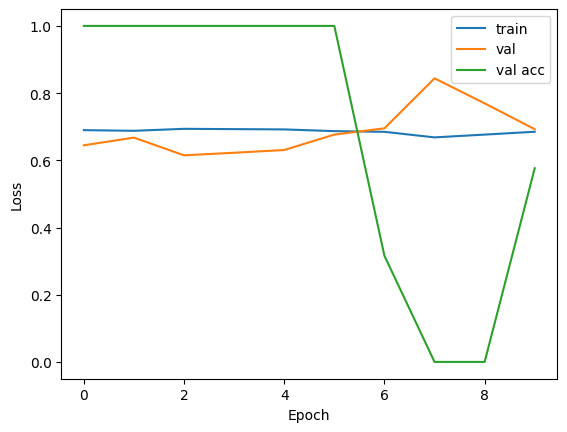

In [ ]:
# plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(running_train_loss, label="train")
plt.plot(running_val_loss, label="val")
plt.plot(running_val_acc, label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

In [ ]:
import numpy as np
print(np.__version__)
print(val_preds)

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA not available")



True
NVIDIA GeForce RTX 3060 Ti
